## 1. Set-up

### 1.1 Imports

In [1]:
# Imports
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import math

### 1.2 Helper Functions

In [2]:
# Encoding and decoding
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

def plot_data(x, y1, y2, xlabel, ylabel):
    plt.plot(x, y1, 'b')
    plt.plot(x, y2, 'r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### 1.3 Device

In [3]:
# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## 2. Data-Preprocessing

### 2.1 Creating DataFrame

In [4]:
def create_df(bios, targets):
    zipped_data = list(zip(bios, targets))
    text_df = pd.DataFrame(zipped_data, columns=['Bios', 'Labels'])
    return text_df

### 2.2 Preprocessing Function

In [5]:
# Preprocessing
def process_data(data, words):
    fake_i = (data == words["[FAKE]"][0])
    real_i = (data == words["[REAL]"][0])
    target_indices = (fake_i + real_i).nonzero()
    num_entries = len(target_indices)
    bio_tensor_list = []
    target_list = []
    entry = 0
    start_i = 0

    while entry < num_entries:
        target_i = target_indices[entry]

        # Size of data and targets
        #print(f"Data size: {data[start_i:target_i].size()}")
        #print(f"Target size: {data[target_i].size()}")

        # Take in a list of tensors and use pad sequence
        bio = data[start_i:target_i]
        target = [1, 0] if data[target_i] == words["[FAKE]"][0] else [0, 1]

        bio_tensor_list.append(torch.tensor(bio).squeeze())
        target_list.append(target)

        start_i = target_i + 1
        entry += 1

    # have largest size be 880
    pad_bias = torch.ones(880)
    bio_tensor_list.append(pad_bias)

    padded_bios = torch.t(pad_sequence(bio_tensor_list)).to(device)
    padded_bios = padded_bios[:-1]
    targets = torch.tensor(target_list).to(device)

    # print("First bio", padded_bios[0].size())
    # print("Second bio", padded_bios[1].size())
    data_df = create_df(padded_bios, targets)
    return data_df

### 2.2.5 Pre-process n-gram Data

In [6]:
def process_ngram(data, words):

    # Features
    data = torch.tensor(data)
    new_len = (math.floor(math.sqrt(len(data))) + 1) ** 2
    pad_arr = [words['<unk>'][0] for i in range(new_len - len(data))]
    pad_arr = torch.tensor(pad_arr)

    padded_data = torch.cat((data, pad_arr), dim=0)
    padded_data = torch.reshape(padded_data, (int(math.sqrt(new_len)), int(math.sqrt(new_len))))
    padded_data = list(map(torch.tensor, padded_data))
    print(len(padded_data))
    print(padded_data[0].size())
    data_df = pd.DataFrame(list(zip(padded_data)), columns=['Bios'])

    return data_df

### 2.3 Dataset Class

In [7]:
class TextDataset(Dataset):
    def __init__(self, data_df):
        self.text_df = data_df
        print("Head of Data", self.text_df.head())
        self.x = self.text_df['Bios']
        #self.y = self.text_df['Labels']

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]#, self.y[idx]

## 3. Models

### 3.1 FFNN

In [8]:
# FeedForward Model
class FFNN(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, dropout):
        super().__init__() 
    
        # Class parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)

        # Embedding Layer
        self.embeds = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layers
        self.fc1 = nn.Linear(880 * d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, 2)

        # Nonlinear Layer
        self.activation = nn.Tanh()

        # Setting weights
        self.init_weights()
                
    # Initialize weights for foward layer
    def init_weights(self):
        weight_range = 0.1
        self.embeds.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()

    # Forward
    def forward(self, src):
        # Embeddings are fed into the forward layer
        embeds = self.embeds(src).view((-1, 880 * self.d_model))
        x = self.dropout(self.activation(self.fc1(embeds)))
        x = self.fc2(x)

        return x

### 3.2 Language FFNN

In [9]:
# FeedForward Model
class LanguageFFNN(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, dropout, ngram_size):
        super().__init__() 
    
        # Class parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.ngram_size = ngram_size
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)

        # Embedding Layers
        self.input_embedding = nn.Embedding(self.vocab_size, self.d_model)
        # self.output_embedding =  nn.Embedding(self.vocab_size, self.d_model)
        
        # self.embeds = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layers
        self.fc1 = nn.Linear(ngram_size * d_model, self.d_model)
        # self.fc2 = nn.Linear(d_hidden, self.vocab_size)
        self.output_embedding = nn.Linear(self.d_model, self.vocab_size)

        # Nonlinear Layer
        self.activation = nn.ReLU()

        # Setting weights
        self.init_weights()
                
    # Initialize weights for foward layer
    def init_weights(self):
        weight_range = 0.1
        # tie embedding layers
        #self.output_embedding.weight.data = self.input_embedding.weight.data
        
        self.input_embedding.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()


    # Forward
    def forward(self, src):
        # Embeddings are fed into the forward layer
        embeds = self.input_embedding(src).view(-1, self.d_model * self.ngram_size)
        x = self.dropout(self.activation(self.fc1(embeds)))
        x = self.output_embedding(x).view(-1, self.vocab_size)
        x = F.log_softmax(x, dim=1)
        return x

### 3.3 LSTM

In [10]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, n_layers, dropout_rate, seq_len):
        super().__init__()
        
        # Class Parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model
        self.dropout = dropout_rate
        self.seq_len = seq_len

        # Embedding Layers
        self.input_embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.output_embedding = nn.Linear(self.d_model, self.vocab_size)

        # Linear Layer
        self.fc1 = nn.Linear(seq_len * d_model, self.d_model)

        # LSTM Cell
        self.lstm = nn.LSTM(input_size=self.d_model, hidden_size=self.d_hidden, num_layers=self.n_layers, dropout=self.dropout)
        
    # Forward
    def forward(self, src, hc):
        embeds = self.input_embedding(src).view(-1, self.d_model * self.seq_len)
        x = self.fc1(embeds)
        preds, hc = self.lstm(x, hc)
        preds = self.dropout(preds)
        preds = self.output_embedding(preds).view(-1, self.vocab_size)
        return [preds, hc]
    
    def init_weights(self):
        pass        
    
    def detach_hidden(self, hc):
        (hidden, cell) = hc
        hidden.detach()
        cell.detach()
        return [hidden, cell]

## 4. Training

In [11]:
def get_accuracy(preds, truth):
    preds, truth = np.array(preds.cpu()), np.array(truth.cpu())
    acc_arr = preds == truth
    return np.sum(acc_arr) / len(acc_arr)

### 4.1 Train One Epoch

In [12]:
# Train Model Function
def train_model(model, train_data_loader, optimizer, criterion):
        #print(data.size())
        cur_loss = 0
        cur_acc = 0
        num_batches = len(train_data_loader)
        
        for batch_idx, (train_features, train_labels) in enumerate(train_data_loader):
            optimizer.zero_grad()
            # print(f"Train Features: {train_features[0]}")
            logit_output = model(train_features)
            probs = torch.softmax(logit_output, dim=1)
            loss = criterion(probs.float(), train_labels.float())
            preds = torch.argmax(logit_output, dim=1)
            truth = torch.argmax(train_labels, dim=1)
            # print(f"Logit Output = {logit_output}")
            # print(f"Probs = {probs}; Preds = {preds}\nLabels = {train_labels}; Truth = {truth}\n")

            acc = get_accuracy(preds, truth)

            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            cur_acc += acc

        # Shapes of output and targets
        # print(f"Output size: {probs.size()}")
        # print(f"Target size: {train_labels.size()}")

        # loss = F.mse_loss(output.float(), targets.float())
        # output = torch.argmax(output, dim=1)

        av_loss = cur_loss / num_batches
        av_acc = cur_acc / num_batches
        return av_loss, av_acc

### 4.2 Training over Epochs

In [13]:
def train_loop(model, data_df, epochs, optimizer, criterion):

    data = TextDataset(data_df)
    train_dataloader = DataLoader(data, batch_size=4000, shuffle=True)
    average_loss_list = []
    average_perp_list = []
    average_acc_list = []
    epoch_list = []
    
    for epoch in range(0, epochs):
        model.train(True)
        average_loss, average_accuracy = train_model(model, train_dataloader, optimizer, criterion)
        average_perplexity = math.exp(average_loss)
        model.train(False)

        average_loss_list.append(average_loss)
        average_perp_list.append(average_perplexity)
        average_acc_list.append(average_accuracy)
        epoch_list.append(epoch)
    
        print(f"At Epoch {epoch}, Accuracy = {average_accuracy} & Loss = {average_loss}")
        print(f"At Epoch {epoch}, Accuracy = {average_accuracy} & Loss = {average_loss}")

    plot_data(epoch_list, average_loss_list, 'Epoch', 'Loss')
    plot_data(epoch_list, average_perp_list, 'Epoch', 'Perplexity')
    plot_data(epoch_list, average_acc_list, 'Epoch', 'Accuracy')

### 4.3 Train n-gram Model

In [14]:
def valid_metrics(model, valid_data_loader, ngram_size, vocab_size, criterion):
    num_batches = len(valid_data_loader)

    total_loss = 0
    total_acc = 0
    
    for batch_idx, valid_features in enumerate(valid_data_loader):

        cur_loss = 0
        cur_acc = 0
        word_idx = 0

        print(f"Valid Batch Num: {batch_idx}")
        # Sliding Window
        for _ in range(len(valid_features[0]) - ngram_size):
            # print(f"Word Idx: {word_idx}")
            start = word_idx
            stop = word_idx + ngram_size

            # new_features = torch.tensor(list(map(lambda x: torch.select(), train_features)))
            new_features = torch.narrow(valid_features, 1, start, ngram_size).to(device)
            new_labels = torch.narrow(valid_features, 1, stop, 1).squeeze().to(device)
            new_class_labels = []

            new_class_labels = F.one_hot(new_labels, vocab_size)
            
            probs = model(new_features)
            pseudo_probs = torch.gather(probs, 1, torch.tensor(new_labels).unsqueeze(1))
            pseudo_probs = - torch.log(pseudo_probs) / len(valid_features)
        
            preds = torch.argmax(probs, dim=1)
            truth = torch.argmax(new_class_labels, dim=1)

            acc = get_accuracy(preds, truth)
            #loss = criterion(probs.float(), new_class_labels.float())
            loss = criterion(probs, new_labels)

            cur_loss += loss.item()
            cur_acc += acc

            word_idx += 1

        av_loss = cur_loss / word_idx
        av_acc = cur_acc / word_idx
        print("Average Valid Batch Loss", av_loss)
        print("Average Valid Batch Accuracy", av_acc)

        total_loss += av_loss
        total_acc += av_acc

    av_loss = total_loss / num_batches
    av_acc = total_acc / num_batches
    return av_loss, av_acc

In [15]:
# Train Model Function
def train_ngram_model(model, train_data_loader, valid_data_loader, optimizer, criterion, ngram_size, vocab_size):
    
    num_batches = len(train_data_loader)
    total_loss = 0
    total_acc = 0
        
    for batch_idx, train_features in enumerate(train_data_loader):
        optimizer.zero_grad()

        cur_loss = 0
        cur_acc = 0
        word_idx = 0

        print(f"Batch Num: {batch_idx}")
        # Sliding Window
        for _ in range(len(train_features[0]) - ngram_size):
            # print(f"Word Idx: {word_idx}")
            start = word_idx
            stop = word_idx + ngram_size

            # new_features = torch.tensor(list(map(lambda x: torch.select(), train_features)))
            new_features = torch.narrow(train_features, 1, start, ngram_size).to(device)
            new_labels = torch.narrow(train_features, 1, stop, 1).squeeze().to(device)
            new_class_labels = []

            new_class_labels = F.one_hot(new_labels, vocab_size)
            
            probs = model(new_features)
            pseudo_probs = torch.gather(probs, 1, torch.tensor(new_labels).unsqueeze(1))
            pseudo_probs = - torch.log(pseudo_probs) / len(train_features)
        
            preds = torch.argmax(probs, dim=1)
            truth = torch.argmax(new_class_labels, dim=1)

            acc = get_accuracy(preds, truth)
            #loss = criterion(probs.float(), new_class_labels.float())
            loss = criterion(probs, new_labels)

            cur_loss += loss.item()
            cur_acc += acc

            word_idx += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        av_loss = cur_loss / word_idx
        av_acc = cur_acc / word_idx
        print("Average Batch Loss", av_loss)
        print("Average Batch Accuracy", av_acc)

        total_loss += av_loss
        total_acc += av_acc

    av_valid_loss, av_valid_acc = valid_metrics(model, valid_data_loader, ngram_size, vocab_size, criterion)

    av_loss = total_loss / num_batches
    av_acc = total_acc / num_batches
    return av_loss, av_acc, av_valid_loss, av_valid_acc

### 4.4 Train n-gram over Epochs

In [16]:
def train_ngram_loop(model, train_data_df, valid_data_df, epochs, optimizer, criterion, batch_size):

    train_data = TextDataset(train_data_df)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_data = TextDataset(valid_data_df)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    average_loss_list = []
    average_perp_list = []
    average_acc_list = []
    average_valid_loss_list = []
    average_valid_perp_list = []
    average_valid_acc_list = []
    epoch_list = []
    
    for epoch in range(0, epochs):
        model.train(True)
        average_loss, average_accuracy, average_valid_loss, average_valid_accuracy = train_ngram_model(model, train_dataloader, valid_dataloader, optimizer, criterion, model.ngram_size, model.vocab_size)
        average_perplexity = math.exp(average_loss)
        average_valid_perplexity = math.exp(average_valid_loss)
        model.train(False)

        average_loss_list.append(average_loss)
        average_perp_list.append(average_perplexity)
        average_acc_list.append(average_accuracy)
        average_valid_loss_list.append(average_valid_loss)
        average_valid_perp_list.append(average_valid_perplexity)
        average_valid_acc_list.append(average_valid_accuracy)
        epoch_list.append(epoch)
    
        print(f"At Epoch {epoch}, Accuracy = {average_accuracy} & Loss = {average_loss}")
        print(f"At Epoch {epoch}, Valid Accuracy = {average_valid_accuracy} & Valid Loss = {average_valid_loss}")

    plot_data(epoch_list, average_loss_list, average_valid_loss_list, 'Epoch', 'Loss')
    plot_data(epoch_list, average_perp_list, average_valid_perp_list, 'Epoch', 'Perplexity')
    plot_data(epoch_list, average_acc_list, average_valid_acc_list,'Epoch', 'Accuracy')

### 4.5 Valid Histogram

In [17]:
def valid_histogram(model, validation_data, ngram_size, words):
    bio_len = 0
    bio_probs_real = []
    bio_probs_fake = []
    total_bio_prob = 0
    i = 0

    while i < len(validation_data) - (ngram_size+1):
        feature = validation_data[i:i+ngram_size].to(device)
        label = validation_data[i+ngram_size]
        probs = model(feature).squeeze()
        label_prob = probs[label]

        if i % 50000 == 0: 
          print(f"{i}/{len(validation_data)}")
          print(label_prob)

        if label_prob == 0:
          label_prob += 0.0001

        #pseudo_prob = -math.log(label_prob)
                
        if validation_data[i+ngram_size+1] == words['[REAL]'][0]:
           bio_probs_real.append(total_bio_prob / bio_len)
           bio_len = 0
           total_bio_prob = 0
           i += 4
        elif validation_data[i+ngram_size+1] == words['[FAKE]'][0]:
           bio_probs_fake.append(total_bio_prob / bio_len)
           bio_len = 0
           total_bio_prob = 0
           i += 4
        else:
            total_bio_prob += label_prob
            bio_len += 1
            i += 1

    #bio_probs_real = list(filter(lambda x: (x > 9.21), bio_probs_real))
    #bio_probs_fake = list(filter(lambda x: (x > 9.21), bio_probs_fake))
    print(bio_probs_real)
    print(bio_probs_fake)
    plt.hist(bio_probs_real, label='Reals', alpha=0.5, bins=100)
    plt.hist(bio_probs_fake, label='Fakes', alpha=0.5, bins=100)
    plt.legend(loc='upper left')
    plt.xlabel("Negative Average Log Probs")
    plt.ylabel("Frequency")
    plt.show()           

## 5. Testing Code

In [18]:
def test_model(model, df):
    data = TextDataset(df)
    dataloader = DataLoader(data, batch_size=len(df), shuffle=True)

    for batch_idx, (features, labels) in enumerate(dataloader):
        print(features.size())
        preds = model(features).squeeze()
        preds = torch.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)
        # print(f"Pre-processed truths: {labels}")
        truth = torch.argmax(labels, dim=1)

        # print(f"preds: {preds}")
        # print(f"truth: {truth}")

        acc = get_accuracy(truth, preds)
        confusion_mat = confusion_matrix(truth, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["FAKE", "REAL"])
        disp.plot()
        plt.show()
        # print(f"Confusion Matrix : {confusion_mat}")

 
    return acc

## 5. Running Code

### 5.1 Loading Parameters

In [19]:
class Params:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
            
model_map = {0: 'FFNN', 1: 'LSTM', 2: 'FFNN_CLASSIFY', 3: 'LSTM_CLASSIFY'}
train_map = {0: 'data/real.train.tok', 1: 'data/fake.train.tok', 2: 'data/mix.train.tok'}
valid_map = {0: 'data/real.valid.tok', 1: 'data/fake.valid.tok', 2: 'data/mix.valid.tok'}
test_map = {0: 'data/real.test.tok', 1: 'data/fake.test.tok', 2: 'data/mix.test.tok', 3: 'data/blind.test.tok'}

model_type = model_map[2]
# train_type = [train_map[0], train_map[1]]

# Types of data
train_type = train_map[2]
valid_type = valid_map[2]
test_type = test_map[2]

args = {
    "d_model": 32,
    "d_hidden": 4,
    "n_layers": 3,
    "batch_size": 64,
    "seq_len": 30,
    "printevery": 5000,
    "window": 3,
    "epochs": 5,
    "lr": 0.0001,
    "dropout": 0.35,
    "clip": 2.0,
    "model": model_type,
    "savename": model_type.lower(),
    "loadname": model_type.lower(),
    "trainname": train_type,
    "validname": valid_type,
    "testname": test_type
}

### 5.2 Main Function

In [20]:
# Main Function
def main(args): 
    torch.manual_seed(0)
    
    params = Params(**args)
    train_name = params.trainname
    valid_name = params.validname
    test_name = params.testname
    model_type = params.model
    d_mod = params.d_model
    d_hid = params.d_hidden
    dropout = params.dropout
    epochs = params.epochs
    window = params.window
    batch_size = params.batch_size

    # real, fake = params.trainname
    # [vocab_real, words_real, train_real] = read_encode(real, [], {}, [], 3)
    # [vocab_fake, words_fake, train_fake] = read_encode(fake, [], {}, [], 3)

    # train_features = torch.cat((torch.tensor(train_real), torch.tensor(train_fake)))
    # train_labels = torch.cat((torch.ones(len(train_real)), torch.zeros(len(train_fake))))
    # print(f'train_features: {train_features}')
    # print(f'train_labels: {train_labels}')

    [train_vocab,train_words,train] = read_encode(train_name,[],{},[],3)
    train_data = torch.tensor(train)

    [valid_vocab,valid_words,valid] = read_encode(valid_name,[],{},[],3)
    valid_data = torch.tensor(valid)
    
    print('vocab: %d train: %d' % (len(train_vocab),len(train)))
    # print(f'vocab: {vocab[10:20]}\n \n train: {train[10:20]}')
    print(f'fake id: {train_words["[FAKE]"]}')
    print(f'real id: {train_words["[REAL]"]}')

    # [test_vocab,test_words,test] = read_encode(test_name,vocab,words,[],-1)
    [test_vocab,test_words,test] = read_encode(test_name,[],{},[],3)
    test_data = torch.tensor(test)

    #print('vocab: %d test: %d' % (len(vocab),len(test)))

    vocab_size = len(train_vocab)
    train_df = process_data(train_data, train_words)
    validation_df = process_data(valid_data, valid_words)
    test_df = process_data(test_data, test_words)

    # print(test_df)
    
    if model_type == 'FFNN':
        ffnn_model = FFNN(train_vocab, train_words, d_mod, d_hid, dropout)
        ffnn_model.to(device)
        optimizer = torch.optim.SGD(ffnn_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
        train_loop(ffnn_model, train_df, epochs, optimizer, criterion)
        # print(ffnn_model)
#          {add code to instantiate the model, train for K epochs and save model to disk}
        
    if model_type == 'LSTM':
        pass
#          {add code to instantiate the model, train for K epochs and save model to disk}

    if model_type == 'FFNN_CLASSIFY':
        # ffnn_model = FFNN(train_vocab, train_words, d_mod, d_hid, dropout)
        # ffnn_model.to(device)
        # optimizer = torch.optim.SGD(ffnn_model.parameters(), lr=0.01, momentum=0.9)
        # criterion = nn.BCELoss()
        # train_loop(ffnn_model, train_df, epochs, optimizer, criterion)


        # acc = test_model(ffnn_model, validation_df)
        # print(f"Validation Acc: {acc}")
        
        # acc = test_model(ffnn_model, test_df)
        # print(f"Test Acc: {acc}")

        padded_data_df = process_ngram(train_data, train_words)
        padded_valid_data_df = process_ngram(valid_data, valid_words)
        ngram_model = LanguageFFNN(train_vocab, train_words, d_mod, d_hid, dropout, window)
        ngram_model.to(device)
        optimizer = torch.optim.SGD(ngram_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.NLLLoss()
        train_ngram_loop(ngram_model, padded_data_df, padded_valid_data_df, epochs, optimizer, criterion, batch_size)
        #valid_histogram(ngram_model, valid_data, window, valid_words)

        torch.save(ngram_model.state_dict(), './ngram_model')
#          {add code to instantiate the model, recall model parameters and perform/learn classification}    

    if model_type == 'LSTM_CLASSIFY':
        pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}


### 5.3 Running Main Function

vocab: 35150 train: 3012820
fake id: [122, 3913]
real id: [635, 4049]


<ipython-input-5-04db99e11d97>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_tensor_list.append(torch.tensor(bio).squeeze())
<ipython-input-6-ea24f8a37d3b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
<ipython-input-6-ea24f8a37d3b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_data = list(map(torch.tensor, padded_data))


1736
torch.Size([1736])
606
torch.Size([606])
Head of Data                                                 Bios
0  [tensor(1), tensor(2), tensor(3), tensor(4), t...
1  [tensor(0), tensor(29), tensor(0), tensor(29),...
2  [tensor(930), tensor(931), tensor(923), tensor...
3  [tensor(44), tensor(9), tensor(29), tensor(0),...
4  [tensor(44), tensor(1190), tensor(24), tensor(...
Head of Data                                                 Bios
0  [tensor(1), tensor(2), tensor(3), tensor(4), t...
1  [tensor(231), tensor(17), tensor(25), tensor(1...
2  [tensor(70), tensor(423), tensor(38), tensor(4...
3  [tensor(583), tensor(22), tensor(18), tensor(4...
4  [tensor(38), tensor(726), tensor(25), tensor(6...
Batch Num: 0


<ipython-input-15-4833dde6bca3>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pseudo_probs = torch.gather(probs, 1, torch.tensor(new_labels).unsqueeze(1))


Average Batch Loss 7.855064883510019
Average Batch Accuracy 0.05952466820542412
Batch Num: 1
Average Batch Loss 6.70501851925462
Average Batch Accuracy 0.12092469705712637
Batch Num: 2
Average Batch Loss 6.4182605938765604
Average Batch Accuracy 0.14626911425274092
Batch Num: 3
Average Batch Loss 6.223764106708665
Average Batch Accuracy 0.16134412867859205
Batch Num: 4
Average Batch Loss 6.0776267497441845
Average Batch Accuracy 0.17406592613964225
Batch Num: 5
Average Batch Loss 5.937818755322086
Average Batch Accuracy 0.18321732544720137
Batch Num: 6
Average Batch Loss 5.902758875680121
Average Batch Accuracy 0.18425418349682632
Batch Num: 7
Average Batch Loss 5.810776783700493
Average Batch Accuracy 0.1936039382573572
Batch Num: 8
Average Batch Loss 5.783385487835461
Average Batch Accuracy 0.19787759665320254
Batch Num: 9
Average Batch Loss 5.77778897530346
Average Batch Accuracy 0.19641697922677437
Batch Num: 10
Average Batch Loss 5.6484723267222305
Average Batch Accuracy 0.2021242

<ipython-input-14-e04b155bae11>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pseudo_probs = torch.gather(probs, 1, torch.tensor(new_labels).unsqueeze(1))


Average Valid Batch Loss 9.730970716397364
Average Valid Batch Accuracy 0.03070584577114428
Valid Batch Num: 1
Average Valid Batch Loss 9.71434594782233
Average Valid Batch Accuracy 0.02824419568822554
Valid Batch Num: 2
Average Valid Batch Loss 9.721640098945024
Average Valid Batch Accuracy 0.02933250414593698
Valid Batch Num: 3
Average Valid Batch Loss 9.676166257652675
Average Valid Batch Accuracy 0.0308613184079602
Valid Batch Num: 4
Average Valid Batch Loss 9.704984362841047
Average Valid Batch Accuracy 0.02956571310116086
Valid Batch Num: 5
Average Valid Batch Loss 9.716773208694079
Average Valid Batch Accuracy 0.02920294361525705
Valid Batch Num: 6
Average Valid Batch Loss 9.728261980844374
Average Valid Batch Accuracy 0.028347844112769485
Valid Batch Num: 7
Average Valid Batch Loss 9.70006878063651
Average Valid Batch Accuracy 0.02878834991708126
Valid Batch Num: 8
Average Valid Batch Loss 9.709328800093871
Average Valid Batch Accuracy 0.029643449419568823
Valid Batch Num: 9
Av

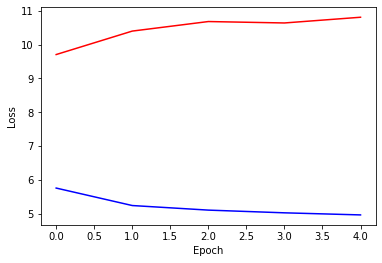

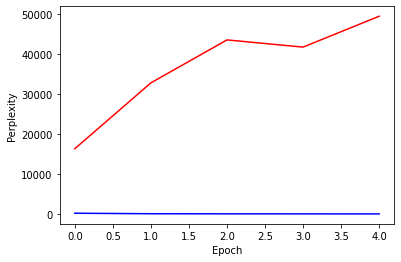

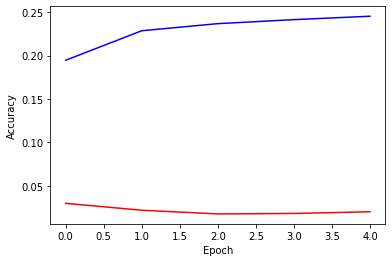

In [21]:
main(args)